In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import os
import math
import pickle
from detect_peaks import detect_peaks
import ruptures as rpt
from numpy.random import seed
seed(60)
from tensorflow import set_random_seed
set_random_seed(60)
#random.seed(42) # f1 30
#random.seed(4300) # f1 0.29
#random.seed(6) # f1 0.29
#random.seed(8) # f1 0.28
#random.seed(50) #f1 0.31
#random.seed(60) #f1 0.34
#random.seed(80) #f1 0.3
#random.seed(0.65) #f1 0.31


import keras
from keras_transformer import get_model
from os import listdir, walk
from os.path import isfile, join
from detect_peaks import detect_peaks
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import ruptures as rpt
import tensorflow as tf
from keras import layers, models
from keras.optimizers import SGD
from keras.layers import LSTM, GRU, Dropout, Dense, Input, Flatten
# from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.models import load_model
from keras import optimizers 
from keras import Model
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn import preprocessing

Using TensorFlow backend.


In [3]:
%run load_dataset.ipynb

In [4]:
# Test 1.1
# all_patients = ['3001','3002','3003','3004','4001','4002']
# all_validate = ['3005','4003']
# Test 1.2
all_patients = ['3001','3002','3003','3004','4001','4002','1001','1002','1003','1004','1005','1006','1007','1008','1009','1010','1011','1012','1013','1014']
all_validate = ['3005','4003','1015','1016']

In [5]:
X_all_p, y_all_p, subj_all_p, ts_all_p, hr_all_p = load_all_data(all_patients)
X_all_v, y_all_v, subj_all_v, ts_all_v, hr_all_v = load_all_data(all_validate)

Loading 3001's data
Loading 3002's data
Loading 3003's data
Loading 3004's data
Loading 4001's data
Loading 4002's data
Loading 1001's data
Loading 1002's data
Loading 1003's data
Loading 1004's data
Loading 1005's data
Loading 1006's data
Loading 1007's data
Loading 1008's data
Loading 1009's data
Loading 1010's data
Loading 1011's data
Loading 1012's data
Loading 1013's data
Loading 1014's data
Finished loading
Loading 3005's data
Loading 4003's data
Loading 1015's data
Loading 1016's data
Finished loading


In [6]:
%run preprocessing.ipynb

In [7]:
new_label_list = [0,1,2,3]
new_label_dict = {
    0: 'sit',
    1: 'sleep',
    2: 'stand',
    3: 'walk'
}

colors = ['r','g','b','navy','turquoise','blue','darkviolet','gold','pink']

In [8]:
all_subjects = all_patients

plotting  sit
(3, 374)
(3, 374)
(3, 374)
(3, 374)
(3, 1491)
(3, 1491)
(3, 374)
(3, 372)
(3, 379)
(3, 380)
(3, 361)
(3, 386)
(3, 373)
(3, 373)
(3, 381)
(3, 374)
(3, 374)
(3, 374)
(3, 374)
(3, 372)


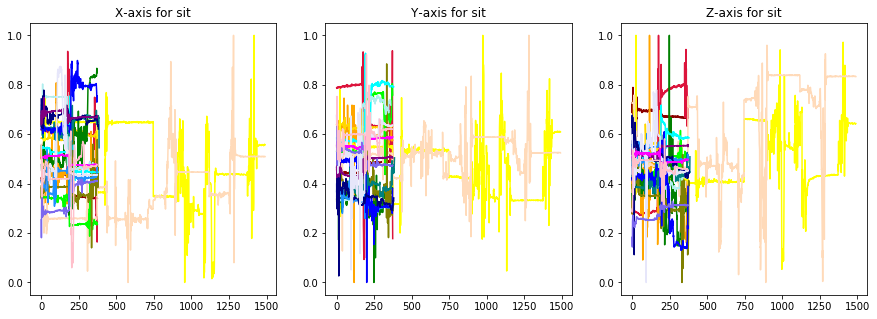

plotting  sleep
(3, 374)
(3, 374)
(3, 372)
(3, 380)
(3, 746)
(3, 745)
(3, 379)
(3, 368)
(3, 367)
(3, 186)
(3, 386)
(3, 391)
(3, 374)
(3, 374)
(3, 374)
(3, 381)
(3, 374)
(3, 374)
(3, 374)
(3, 378)


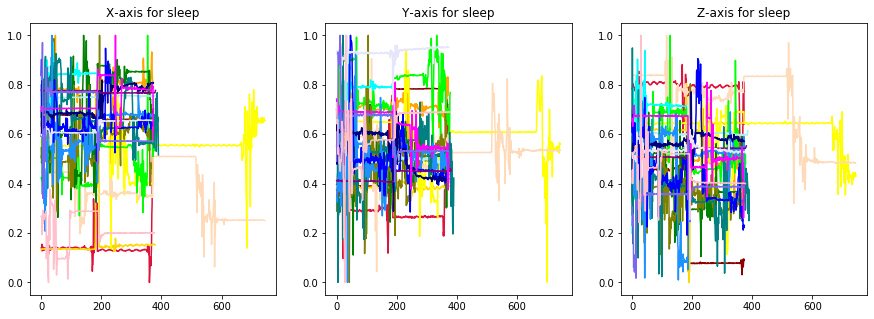

plotting  stand
(3, 573)
(3, 561)
(3, 558)
(3, 561)
(3, 1116)
(3, 1117)
(3, 553)
(3, 560)
(3, 561)
(3, 517)
(3, 577)
(3, 566)
(3, 561)
(3, 560)
(3, 561)
(3, 561)
(3, 560)
(3, 572)
(3, 559)
(3, 558)


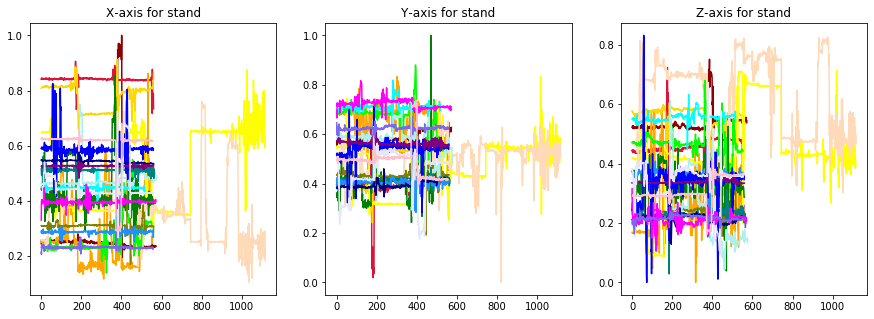

plotting  walk
(3, 386)
(3, 374)
(3, 379)
(3, 373)
(3, 738)
(3, 746)
(3, 859)
(3, 709)
(3, 716)
(3, 741)
(3, 664)
(3, 723)
(3, 710)
(3, 747)
(3, 891)
(3, 703)
(3, 859)
(3, 673)
(3, 902)
(3, 848)


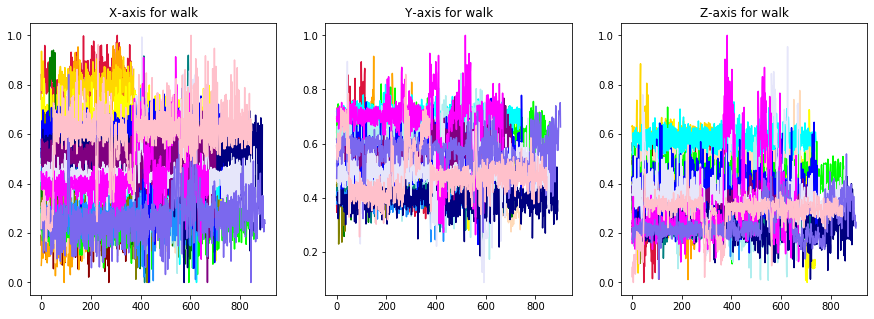

In [9]:
X_label, y_label = label_grouping(X_all_p, y_all_p, subj_all_p, all_patients, new_label_list)
plot_all_label(X_label, y_all_p, new_label_list, new_label_dict)

## No HR

In [10]:
# this shape only Dense
x_pure, y_pure = prepare_pure_label(X_all_p, y_all_p, subj_all_p, all_patients, new_label_list)
x_valid,y_valid = prepare_pure_label(X_all_v, y_all_v, subj_all_v, all_validate, new_label_list)

In [23]:
x_pure

array([[[0.41180611, 0.42532026, 0.42062785],
        [0.42325559, 0.41875088, 0.40730138],
        [0.39359956, 0.44502837, 0.48463235],
        ...,
        [0.700884  , 0.69425414, 0.69690608],
        [0.700663  , 0.69867403, 0.69867403],
        [0.69779006, 0.6962431 , 0.69779006]],

       [[0.42532026, 0.42062785, 0.42325559],
        [0.41875088, 0.40730138, 0.39359956],
        [0.44502837, 0.48463235, 0.43545588],
        ...,
        [0.69425414, 0.69690608, 0.700663  ],
        [0.69867403, 0.69867403, 0.69779006],
        [0.6962431 , 0.69779006, 0.70132599]],

       [[0.42062785, 0.42325559, 0.41875088],
        [0.40730138, 0.39359956, 0.44502837],
        [0.48463235, 0.43545588, 0.465675  ],
        ...,
        [0.69690608, 0.700663  , 0.69867403],
        [0.69867403, 0.69779006, 0.6962431 ],
        [0.69779006, 0.70132599, 0.69469614]],

       ...,

       [[0.66380761, 0.55638787, 0.58410427],
        [0.58470353, 0.86890892, 0.65332034],
        [0.61481704, 0

In [12]:
x_valid.size

1401660

In [10]:
x_pure.shape

(43609, 180)

In [ ]:
# This reshape only cnn to GRU/LSTM
x_pure = x_pure.reshape(-1,60,3,1)
x_valid = x_valid.reshape(-1,60,3,1)

In [13]:
# This reshape other model
x_pure = x_pure.reshape(-1,60,3)
x_valid = x_valid.reshape(-1,60,3)

In [14]:
y_pure = np_utils.to_categorical(y_pure, 4)
y_valid = np_utils.to_categorical(y_valid, 4)

In [16]:
x_pure.shape

(43609, 60, 3)

In [13]:
y_pure.shape

(43609, 4)

In [14]:
x_valid.shape

(7787, 60, 3)

In [15]:
def buildModelDense():
    inp = layers.Input(shape=(180,))
    mod = layers.Dense(256, activation="relu")(inp)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(128, activation="relu")(mod)
    mod = layers.Dropout(0.2)(mod)
    out = layers.Dense(4, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def buildModelGru():
    inp = layers.Input(shape=(60,3,))
    mod = layers.GRU(256, activation="tanh", return_sequences=True)(inp)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.GRU(256, activation="tanh", return_sequences=False)(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(256, activation="relu")(mod)
#     mod = layers.Flatten()(mod)
    out = layers.Dense(4, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def buildModelCNNGRU():
    inp = layers.Input(shape=(60,3,1))
    mod = layers.TimeDistributed(layers.Conv1D(64, 3, activation="relu"))(inp)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.TimeDistributed(layers.Flatten())(mod)
    mod = layers.GRU(64, activation="tanh", return_sequences=True)(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Flatten()(mod)
    mod = layers.Dense(64, activation="relu")(mod)
    mod = layers.Dropout(0.2)(mod)
    out = layers.Dense(4, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def buildModelCNN():
    inp = layers.Input(shape=(60,3,))
    mod = layers.Conv1D(64, 3, activation="relu")(inp)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Conv1D(64, 3, activation="relu")(mod)
    mod = layers.MaxPooling1D(2)(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Flatten()(mod)
    mod = layers.Dense(64, activation="relu")(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(32, activation="relu")(mod)
    mod = layers.Dropout(0.2)(mod)
    out = layers.Dense(4, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def buildModelCNN2D():
    inp = layers.Input(shape=(60,3,1))
    mod = layers.Conv2D(64, (5,3), activation="relu")(inp)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Conv2D(64, (5,3), activation="relu")(mod)
    mod = layers.MaxPooling1D(2)(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Flatten()(mod)
    mod = layers.Dense(64, activation="relu")(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(32, activation="relu")(mod)
    mod = layers.Dropout(0.2)(mod)
    out = layers.Dense(4, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def buildModelCNNLSTM():
    inp = layers.Input(shape=(60,3,1))
    mod = layers.TimeDistributed(layers.Conv1D(64, 3, activation="relu"))(inp)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.TimeDistributed(layers.Flatten())(mod)
    mod = layers.LSTM(64, activation="tanh", return_sequences=False)(mod)
    mod = layers.Dropout(0.2)(mod)
#     mod = layers.Flatten()(mod)
    
    mod = layers.Dense(64, activation="relu")(mod)
    mod = layers.Dropout(0.2)(mod)
    out = layers.Dense(4, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def buildModelLstm():
    inp = layers.Input(shape=(60,3,))
    mod = layers.LSTM(64, activation="tanh", return_sequences=True)(inp)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.LSTM(64, activation="tanh", return_sequences=False)(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(512, activation="relu")(mod)
#     mod = layers.Flatten()(mod)
    mod = layers.Dropout(0.2)(mod)
    out = layers.Dense(4, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def buildDTW(x,y):
    distance, path = fastdtw(x, y, dist=euclidean)
    print(distance)
    return distance,path

def buildLSTMBi1():
    inp = layers.Input(shape=(60,3,))
    mod = layers.Bidirectional(LSTM(64, activation="relu", return_sequences=True, recurrent_dropout=0.2))(inp)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Bidirectional(LSTM(64, activation="relu", return_sequences=True, recurrent_dropout=0.2))(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(512, activation="relu")(mod)
    mod = layers.Flatten()(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(256, activation="relu")(mod)
    out = layers.Dense(4, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model
def buildLSTMBi2():
    inp = layers.Input(shape=(60,3,))
    mod = layers.Bidirectional(LSTM(64, activation="tanh", return_sequences=True, recurrent_dropout=0.2))(inp)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Bidirectional(LSTM(64, activation="tanh", return_sequences=True, recurrent_dropout=0.2))(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(512, activation="relu")(mod)
    mod = layers.Flatten()(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(256, activation="relu")(mod)
    out = layers.Dense(4, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model
def buildLSTMBi3():
    inp = layers.Input(shape=(60,3,))
    mod = layers.Bidirectional(LSTM(64, activation="relu", return_sequences=True, recurrent_dropout=0.2))(inp)
#     mod = layers.BatchNormalization()(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Bidirectional(LSTM(64, activation="relu", return_sequences=False, recurrent_dropout=0.2))(mod)
#     mod = layers.BatchNormalization()(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(512, activation="relu")(mod)
#     mod = layers.Flatten()(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(256, activation="relu")(mod)
    out = layers.Dense(4, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    # gradient clipping and default opt is adam
#     opt = SGD(lr=0.01, momentum=0.9, clipvalue=0.5)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def buildLSTMBi3_2():
    inp = layers.Input(shape=(60,3,))
    mod = layers.Bidirectional(LSTM(64, activation="relu", return_sequences=True, recurrent_dropout=0.2))(inp)
    mod = layers.BatchNormalization()(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Bidirectional(LSTM(64, activation="relu", return_sequences=False, recurrent_dropout=0.2))(mod)
    mod = layers.BatchNormalization()(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(512, activation="relu")(mod)
#     mod = layers.Flatten()(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(256, activation="relu")(mod)
    out = layers.Dense(4, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    # gradient clipping and default opt is adam
#     opt = SGD(lr=0.01, momentum=0.9, clipvalue=0.5)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def buildLSTMBi4():
    inp = layers.Input(shape=(60,3,))
    mod = layers.Bidirectional(LSTM(64, activation="tanh", return_sequences=True, recurrent_dropout=0.2))(inp)
    mod = layers.BatchNormalization()(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Bidirectional(LSTM(64, activation="tanh", return_sequences=False, recurrent_dropout=0.2))(mod)
    mod = layers.BatchNormalization()(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(512, activation="relu")(mod)
#     mod = layers.Flatten()(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(256, activation="relu")(mod)
    out = layers.Dense(4, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model
def buildLSTMBi5():
    inp = layers.Input(shape=(60,3,))
    mod = layers.Bidirectional(LSTM(64, activation="relu", return_sequences=True, recurrent_dropout=0.2))(inp)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Bidirectional(LSTM(64, activation="tanh", return_sequences=False, recurrent_dropout=0.2))(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(512, activation="relu")(mod)
#     mod = layers.Flatten()(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(256, activation="relu")(mod)
    out = layers.Dense(4, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model
def buildLSTMBi6():
    inp = layers.Input(shape=(60,3,))
    mod = layers.Bidirectional(LSTM(64, activation="tanh", return_sequences=True, recurrent_dropout=0.2))(inp)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Bidirectional(LSTM(64, activation="relu", return_sequences=False, recurrent_dropout=0.2))(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(512, activation="relu")(mod)
#     mod = layers.Flatten()(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(256, activation="relu")(mod)
    out = layers.Dense(4, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def transformer():
    model = get_model(token_num=len(new_label_dict),embed_dim=30,encoder_num=3,decoder_num=2,head_num=3,hidden_dim=120,
    attention_activation='relu',feed_forward_activation='relu',
    dropout_rate=0.05,embed_weights=np.random.random((4, 30)))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

## Combine HR

In [ ]:
# Preprecess with HR
x_pure, y_pure = prepare_pure_labelWithHR(X_all_p, y_all_p,hr_all_p, subj_all_p, all_patients, new_label_list)
x_valid,y_valid = prepare_pure_labelWithHR(X_all_v, y_all_v,hr_all_v, subj_all_v, all_validate, new_label_list)

In [ ]:
# This reshape only cnn to GRU/LSTM
x_pure = x_pure.reshape(-1,60,4,1)
x_valid = x_valid.reshape(-1,60,4,1)

In [ ]:
# This reshape other model
x_pure = x_pure.reshape(-1,60,4)
x_valid = x_valid.reshape(-1,60,4)

In [ ]:
y_pure = np_utils.to_categorical(y_pure, 4)
y_valid = np_utils.to_categorical(y_valid, 4)

In [ ]:
y_pure.shape

In [ ]:
x_valid.shape

In [ ]:
def buildModelDense():
    inp = layers.Input(shape=(240,))
    mod = layers.Dense(256, activation="relu")(inp)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(128, activation="relu")(mod)
    mod = layers.Dropout(0.2)(mod)
    out = layers.Dense(4, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def buildModelGru():
    inp = layers.Input(shape=(60,4,))
    mod = layers.GRU(256, activation="relu", return_sequences=True)(inp)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.GRU(256, activation="relu", return_sequences=True)(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(256, activation="relu")(mod)
    mod = layers.Flatten()(mod)
    out = layers.Dense(4, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def buildModelCNNGRU():
    inp = layers.Input(shape=(60,4,1))
    mod = layers.TimeDistributed(layers.Conv1D(64, 3, activation="relu"))(inp)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.TimeDistributed(layers.Flatten())(mod)
    mod = layers.GRU(64, activation="relu", return_sequences=True)(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Flatten()(mod)
    mod = layers.Dense(64, activation="relu")(mod)
    mod = layers.Dropout(0.2)(mod)
    out = layers.Dense(4, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def buildModelCNN():
    inp = layers.Input(shape=(60,4,))
    mod = layers.Conv1D(64, 3, activation="relu")(inp)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Conv1D(64, 3, activation="relu")(mod)
    mod = layers.MaxPooling1D(2)(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Flatten()(mod)
    mod = layers.Dense(64, activation="relu")(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(32, activation="relu")(mod)
    mod = layers.Dropout(0.2)(mod)
    out = layers.Dense(4, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def buildModelCNN2D():
    inp = layers.Input(shape=(60,4,1))
    mod = layers.Conv2D(64, (5,3), activation="relu")(inp)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Conv2D(64, (5,3), activation="relu")(mod)
    mod = layers.MaxPooling1D(2)(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Flatten()(mod)
    mod = layers.Dense(64, activation="relu")(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(32, activation="relu")(mod)
    mod = layers.Dropout(0.2)(mod)
    out = layers.Dense(4, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def buildModelCNNLSTM():
    inp = layers.Input(shape=(60,4,1))
    mod = layers.TimeDistributed(layers.Conv1D(64, 3, activation="relu"))(inp)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.TimeDistributed(layers.Flatten())(mod)
    mod = layers.LSTM(64, activation="relu", return_sequences=True)(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Flatten()(mod)
    
    mod = layers.Dense(64, activation="relu")(mod)
    mod = layers.Dropout(0.2)(mod)
    out = layers.Dense(4, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def buildModelLstm():
    inp = layers.Input(shape=(60,4,))
    mod = layers.LSTM(64, activation="tanh", return_sequences=True)(inp)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.LSTM(64, activation="tanh", return_sequences=False)(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(256, activation="relu")(mod)
#     mod = layers.Flatten()(mod)
    mod = layers.Dropout(0.2)(mod)
    out = layers.Dense(4, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def buildDTW(x,y):
    distance, path = fastdtw(x, y, dist=euclidean)
    print(distance)
    return distance,path

def buildLSTMBi():
    inp = layers.Input(shape=(60,4,))
    mod = layers.Bidirectional(LSTM(64, activation="relu", return_sequences=True, recurrent_dropout=0.1))(inp)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Bidirectional(LSTM(64, activation="relu", return_sequences=True, recurrent_dropout=0.1))(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(256, activation="relu")(mod)
    mod = layers.Flatten()(mod)
    mod = layers.Dropout(0.2)(mod)
    out = layers.Dense(4, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

## Fit model

In [ ]:
# X_train, X_valid, y_train,  y_valid = train_test_split(x_pure, y_pure, test_size=0.2, random_state=200)

In [16]:
Epoch = 100
batch = 128
early_stopping = EarlyStopping(monitor='val_loss',patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=10, min_lr=0.001)

In [17]:
# model_1 = buildModelDense()
# model_2 = buildModelGru()
# model_3 = buildModelCNNGRU()
# model_4 = buildModelCNN()
# model_5 = buildModelCNNLSTM()
# model_6 = buildModelLstm()
# model_7 = buildModelCNN2D()
# model_8 = buildDTW(x_pure,y_pure)
# model_91 = buildLSTMBi1()
# model_92 = buildLSTMBi2()
model_93 = buildLSTMBi3()
model_932 = buildLSTMBi3_2()
# model_94 = buildLSTMBi4()
# model_95 = buildLSTMBi5()
# model_96 = buildLSTMBi6()
# model_10 = transformer()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [87]:
#model_1.summary()
# model_2.summary()
# model_3.summary()
# model_4.summary()
# model_5.summary()
# model_6.summary()
# model_7.summary()

In [18]:
# history_1 = model_1.fit(x_pure,y_pure,batch_size=batch,epochs=Epoch,validation_data=(x_valid, y_valid),verbose=1, callbacks = [early_stopping,reduce_lr])
# history_2 = model_2.fit(x_pure,y_pure,batch_size=batch,epochs=Epoch,validation_data=(x_valid, y_valid),verbose=1, callbacks = [early_stopping,reduce_lr])
# history_3 = model_3.fit(x_pure,y_pure,batch_size=batch,epochs=Epoch,validation_data=(x_valid, y_valid),verbose=1, callbacks = [early_stopping,reduce_lr])
# history_4 = model_4.fit(x_pure,y_pure,batch_size=batch,epochs=Epoch,validation_data=(x_valid, y_valid),verbose=1, callbacks = [early_stopping,reduce_lr])
# history_5 = model_5.fit(x_pure,y_pure,batch_size=batch,epochs=Epoch,validation_data=(x_valid, y_valid),verbose=1, callbacks = [early_stopping,reduce_lr])
# history_6 = model_6.fit(x_pure,y_pure,batch_size=batch,epochs=Epoch,validation_data=(x_valid, y_valid),verbose=1, callbacks = [early_stopping,reduce_lr])
# history_7 = model_7.fit(x_pure,y_pure,batch_size=batch,epochs=Epoch,validation_data=(x_valid, y_valid),verbose=1, callbacks = [early_stopping,reduce_lr])
# history_91 = model_91.fit(x_pure,y_pure,batch_size=batch,epochs=Epoch,validation_data=(x_valid, y_valid),verbose=1, callbacks = [early_stopping,reduce_lr])
# history_92 = model_92.fit(x_pure,y_pure,batch_size=batch,epochs=Epoch,validation_data=(x_valid, y_valid),verbose=1, callbacks = [early_stopping,reduce_lr])
history_93 = model_93.fit(x_pure,y_pure,batch_size=batch,epochs=Epoch,validation_data=(x_valid, y_valid),verbose=1, callbacks = [early_stopping,reduce_lr])
history_932 = model_932.fit(x_pure,y_pure,batch_size=batch,epochs=Epoch,validation_data=(x_valid, y_valid),verbose=1, callbacks = [early_stopping,reduce_lr])
# history_94 = model_94.fit(x_pure,y_pure,batch_size=batch,epochs=Epoch,validation_data=(x_valid, y_valid),verbose=1, callbacks = [early_stopping,reduce_lr])
# history_95 = model_95.fit(x_pure,y_pure,batch_size=batch,epochs=Epoch,validation_data=(x_valid, y_valid),verbose=1, callbacks = [early_stopping,reduce_lr])
# history_96 = model_96.fit(x_pure,y_pure,batch_size=batch,epochs=Epoch,validation_data=(x_valid, y_valid),verbose=1, callbacks = [early_stopping,reduce_lr])
# history_10 = model_10.fit(x_pure,y_pure,batch_size=batch,epochs=Epoch,validation_data=(x_valid, y_valid),verbose=1, callbacks = [early_stopping,reduce_lr])


Instructions for updating:
Use tf.cast instead.
Train on 43609 samples, validate on 7787 samples
Epoch 1/100
43609/43609 [==============================] - 218s 5ms/step - loss: 1.1866 - acc: 0.4416 - val_loss: 1.3351 - val_acc: 0.4375
Epoch 2/100
43609/43609 [==============================] - 210s 5ms/step - loss: 0.7926 - acc: 0.6716 - val_loss: 1.2569 - val_acc: 0.5234
Epoch 3/100
43609/43609 [==============================] - 212s 5ms/step - loss: 0.6871 - acc: 0.7154 - val_loss: 1.3924 - val_acc: 0.5378
Epoch 4/100
43609/43609 [==============================] - 213s 5ms/step - loss: 0.6273 - acc: 0.7368 - val_loss: 1.2752 - val_acc: 0.5197
Epoch 5/100
43609/43609 [==============================] - 215s 5ms/step - loss: 0.5680 - acc: 0.7591 - val_loss: 1.2849 - val_acc: 0.5647
Epoch 6/100
43609/43609 [==============================] - 214s 5ms/step - loss: 0.5296 - acc: 0.7737 - val_loss: 1.4616 - val_acc: 0.5367
Epoch 7/100
43609/43609 [==============================] - 213s 5ms/s

In [19]:
%run eval_score.ipynb 

In [67]:
y_pred1 = model_91.predict(x_valid)
y_pred1 = y_pred1.argmax(axis=1)
y_pred2 = model_92.predict(x_valid)
y_pred2 = y_pred2.argmax(axis=1)
y_pred3 = model_93.predict(x_valid)
y_pred3 = y_pred3.argmax(axis=1)
y_pred4 = model_94.predict(x_valid)
y_pred4 = y_pred4.argmax(axis=1)
y_pred5 = model_95.predict(x_valid)
y_pred5 = y_pred5.argmax(axis=1)
y_pred6 = model_96.predict(x_valid)
y_pred6 = y_pred6.argmax(axis=1)

0.44946706048542445


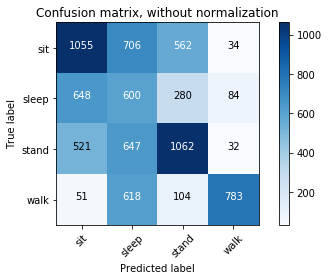

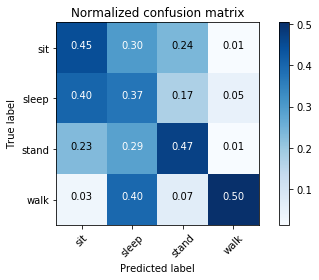

              precision    recall  f1-score   support

         sit       0.46      0.45      0.46      2357
       sleep       0.23      0.37      0.29      1612
       stand       0.53      0.47      0.50      2262
        walk       0.84      0.50      0.63      1556

    accuracy                           0.45      7787
   macro avg       0.52      0.45      0.47      7787
weighted avg       0.51      0.45      0.47      7787

0.3972004623089765


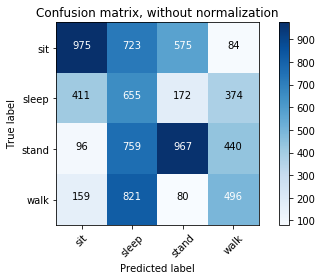

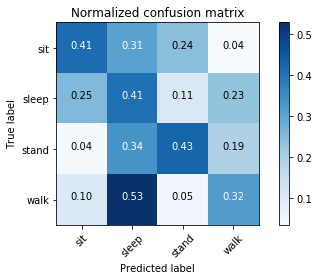

              precision    recall  f1-score   support

         sit       0.59      0.41      0.49      2357
       sleep       0.22      0.41      0.29      1612
       stand       0.54      0.43      0.48      2262
        walk       0.36      0.32      0.34      1556

    accuracy                           0.40      7787
   macro avg       0.43      0.39      0.40      7787
weighted avg       0.45      0.40      0.41      7787

0.5310132271734943


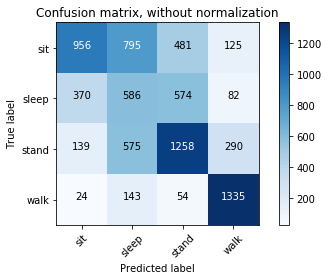

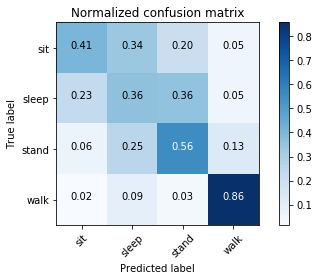

              precision    recall  f1-score   support

         sit       0.64      0.41      0.50      2357
       sleep       0.28      0.36      0.32      1612
       stand       0.53      0.56      0.54      2262
        walk       0.73      0.86      0.79      1556

    accuracy                           0.53      7787
   macro avg       0.55      0.55      0.54      7787
weighted avg       0.55      0.53      0.53      7787

0.3240015410299217


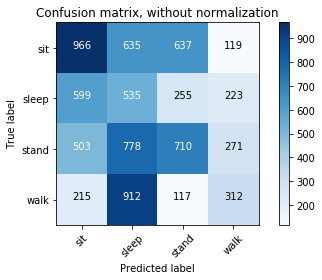

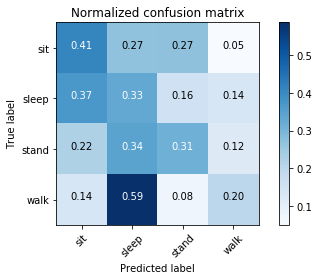

              precision    recall  f1-score   support

         sit       0.42      0.41      0.42      2357
       sleep       0.19      0.33      0.24      1612
       stand       0.41      0.31      0.36      2262
        walk       0.34      0.20      0.25      1556

    accuracy                           0.32      7787
   macro avg       0.34      0.31      0.32      7787
weighted avg       0.35      0.32      0.33      7787

0.4603826890972133


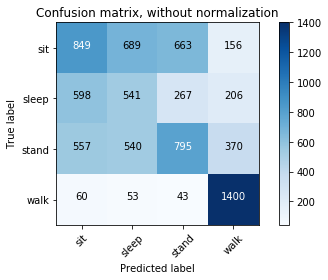

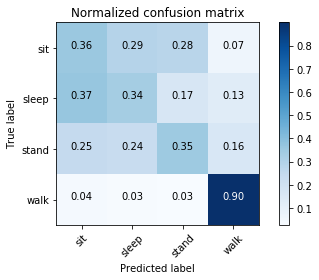

              precision    recall  f1-score   support

         sit       0.41      0.36      0.38      2357
       sleep       0.30      0.34      0.31      1612
       stand       0.45      0.35      0.39      2262
        walk       0.66      0.90      0.76      1556

    accuracy                           0.46      7787
   macro avg       0.45      0.49      0.46      7787
weighted avg       0.45      0.46      0.45      7787

0.419160138692693


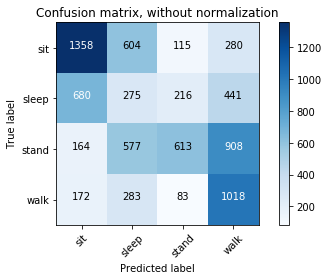

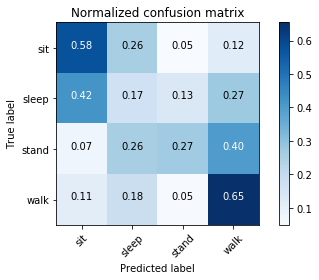

              precision    recall  f1-score   support

         sit       0.57      0.58      0.57      2357
       sleep       0.16      0.17      0.16      1612
       stand       0.60      0.27      0.37      2262
        walk       0.38      0.65      0.48      1556

    accuracy                           0.42      7787
   macro avg       0.43      0.42      0.40      7787
weighted avg       0.46      0.42      0.41      7787



In [69]:
acc = accuracy_score(y_valid.argmax(axis=1), y_pred1)
print(acc)

show_conf_matrix(y_valid.argmax(axis=1), y_pred1, LABELS)
show_clf_report(y_valid.argmax(axis=1), y_pred1, LABELS)
acc = accuracy_score(y_valid.argmax(axis=1), y_pred2)
print(acc)

show_conf_matrix(y_valid.argmax(axis=1), y_pred2, LABELS)
show_clf_report(y_valid.argmax(axis=1), y_pred2, LABELS)
acc = accuracy_score(y_valid.argmax(axis=1), y_pred3)
print(acc)

show_conf_matrix(y_valid.argmax(axis=1), y_pred3, LABELS)
show_clf_report(y_valid.argmax(axis=1), y_pred3, LABELS)
acc = accuracy_score(y_valid.argmax(axis=1), y_pred4)
print(acc)

show_conf_matrix(y_valid.argmax(axis=1), y_pred4, LABELS)
show_clf_report(y_valid.argmax(axis=1), y_pred4, LABELS)
acc = accuracy_score(y_valid.argmax(axis=1), y_pred5)
print(acc)

show_conf_matrix(y_valid.argmax(axis=1), y_pred5, LABELS)
show_clf_report(y_valid.argmax(axis=1), y_pred5, LABELS)
acc = accuracy_score(y_valid.argmax(axis=1), y_pred6)
print(acc)

show_conf_matrix(y_valid.argmax(axis=1), y_pred6, LABELS)
show_clf_report(y_valid.argmax(axis=1), y_pred6, LABELS)

In [20]:
y_pred = model_93.predict(x_valid)
y_pred = y_pred.argmax(axis=1)

0.5703094901759342


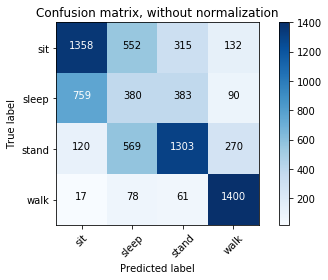

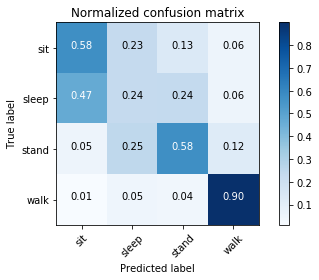

              precision    recall  f1-score   support

         sit       0.60      0.58      0.59      2357
       sleep       0.24      0.24      0.24      1612
       stand       0.63      0.58      0.60      2262
        walk       0.74      0.90      0.81      1556

    accuracy                           0.57      7787
   macro avg       0.55      0.57      0.56      7787
weighted avg       0.56      0.57      0.56      7787



In [21]:
acc = accuracy_score(y_valid.argmax(axis=1), y_pred)
print(acc)

show_conf_matrix(y_valid.argmax(axis=1), y_pred, LABELS)
show_clf_report(y_valid.argmax(axis=1), y_pred, LABELS)

In [22]:
y_pred_1 = model_932.predict(x_valid)
y_pred_1 = y_pred_1.argmax(axis=1)

0.2195967638371645


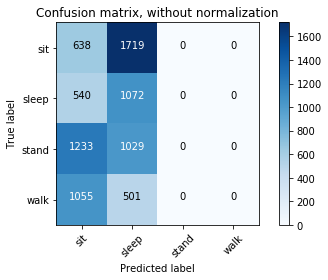

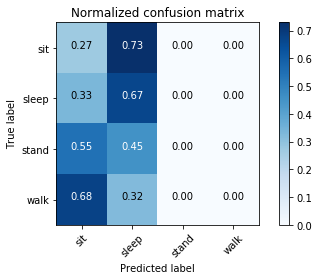

              precision    recall  f1-score   support

         sit       0.18      0.27      0.22      2357
       sleep       0.25      0.67      0.36      1612
       stand       0.00      0.00      0.00      2262
        walk       0.00      0.00      0.00      1556

    accuracy                           0.22      7787
   macro avg       0.11      0.23      0.15      7787
weighted avg       0.11      0.22      0.14      7787



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [23]:
acc = accuracy_score(y_valid.argmax(axis=1), y_pred_1)
print(acc)

show_conf_matrix(y_valid.argmax(axis=1), y_pred_1, LABELS)
show_clf_report(y_valid.argmax(axis=1), y_pred_1, LABELS)

In [337]:
# subj = np.hstack(np.arange(['4001','4002','4003','4004']))
# all_test = [str(i) for i in subj]

In [17]:
all_test_1 = ['3006','4004']
all_test_2 = ['3006','4004','1017','1018']

In [18]:
X_all_test1, y_all_test1, subj_all_test1, ts_all_test1, hr_all_test1 = load_all_data(all_test_1)
X_all_test2, y_all_test2, subj_all_test2, ts_all_test2, hr_all_test2 = load_all_data(all_test_2)

Loading 3006's data
Loading 4004's data
Finished loading
Loading 3006's data
Loading 4004's data
Loading 1017's data
Loading 1018's data
Finished loading


In [110]:
print(X_all_test1)

[[0.25 0.48 0.58]
 [0.25 0.47 0.58]
 [0.25 0.47 0.57]
 ...
 [0.67 0.5  0.19]
 [0.68 0.5  0.19]
 [0.65 0.49 0.18]]


# No HR

In [19]:
x_test_1, y_test_1 = prepare_pure_label(X_all_test1, y_all_test1, subj_all_test1, all_test_1, new_label_list)
x_test_2, y_test_2 = prepare_pure_label(X_all_test2, y_all_test2, subj_all_test2, all_test_2, new_label_list)

In [26]:
# This shape only CNN + Gru/LSTM
x_test_1 = x_test_1.reshape(-1,60,3,1)
x_test_2 = x_test_2.reshape(-1,60,3,1)

In [20]:
x_test_1 = x_test_1.reshape(-1,60,3)
x_test_2 = x_test_2.reshape(-1,60,3)

In [22]:
x_test_2.shape

(8202, 60, 3)

# With HR

In [ ]:
x_test_1, y_test_1 = prepare_pure_labelWithHR(X_all_test1, y_all_test1,hr_all_test1, subj_all_test1, all_test_1, new_label_list)
x_test_2, y_test_2 = prepare_pure_labelWithHR(X_all_test2, y_all_test2,hr_all_test2, subj_all_test2, all_test_2, new_label_list)

In [ ]:
# This shape only CNN + Gru/LSTM
x_test_1 = x_test_1.reshape(-1,60,4,1)
x_test_2 = x_test_2.reshape(-1,60,4,1)

In [ ]:
x_test_1 = x_test_1.reshape(-1,60,4)
x_test_2 = x_test_2.reshape(-1,60,4)

## Predict

In [92]:
y_pred = model_93.predict(x_test_1)
y_pred = y_pred.argmax(axis=1)

0.29448523668176846


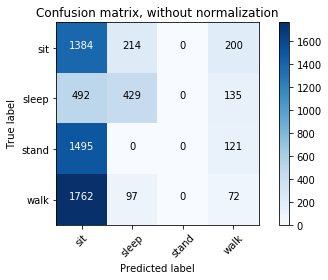

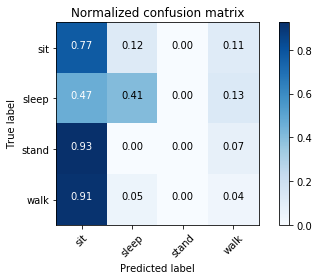

              precision    recall  f1-score   support

         sit       0.27      0.77      0.40      1798
       sleep       0.58      0.41      0.48      1056
       stand       0.00      0.00      0.00      1616
        walk       0.14      0.04      0.06      1931

    accuracy                           0.29      6401
   macro avg       0.25      0.30      0.23      6401
weighted avg       0.21      0.29      0.21      6401



In [93]:
acc = accuracy_score(y_test_1, y_pred)
print(acc)

show_conf_matrix(y_test_1, y_pred, LABELS)
show_clf_report(y_test_1, y_pred, LABELS)

In [94]:
display(pd.DataFrame(zip(y_pred,y_test),columns=['Predicted','Real'])

SyntaxError: unexpected EOF while parsing (<ipython-input-94-3377902c4259>, line 1)

In [95]:
y_pred_2 = model_93.predict(x_test_2)
y_pred_2 = y_pred_2.argmax(axis=1)

0.3505242623750305


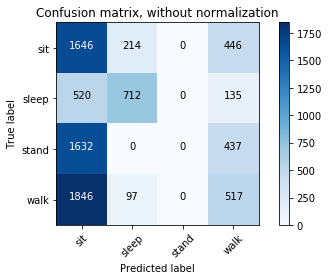

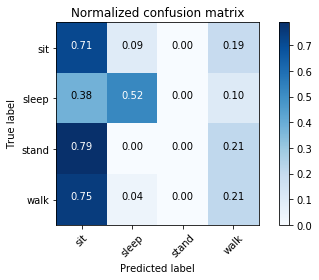

              precision    recall  f1-score   support

         sit       0.29      0.71      0.41      2306
       sleep       0.70      0.52      0.60      1367
       stand       0.00      0.00      0.00      2069
        walk       0.34      0.21      0.26      2460

    accuracy                           0.35      8202
   macro avg       0.33      0.36      0.32      8202
weighted avg       0.30      0.35      0.29      8202



In [96]:
acc = accuracy_score(y_test_2, y_pred_2)
print(acc)

show_conf_matrix(y_test_2, y_pred_2, LABELS)
show_clf_report(y_test_2, y_pred_2, LABELS)

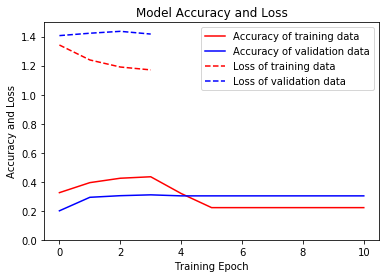

In [190]:
# plt.figure(figsize=(6, 4))
# plt.plot(history_1.history['acc'], 'r', label='Accuracy of training data')
# plt.plot(history_1.history['val_acc'], 'b', label='Accuracy of validation data')
# plt.plot(history_1.history['loss'], 'r--', label='Loss of training data')
# plt.plot(history_1.history['val_loss'], 'b--', label='Loss of validation data')
# plt.title('Model Accuracy and Loss')
# plt.ylabel('Accuracy and Loss')
# plt.xlabel('Training Epoch')
# plt.ylim(0)
# plt.legend()
# plt.show()
# plt.figure(figsize=(6, 4))
# plt.plot(history_2.history['acc'], 'r', label='Accuracy of training data')
# plt.plot(history_2.history['val_acc'], 'b', label='Accuracy of validation data')
# plt.plot(history_2.history['loss'], 'r--', label='Loss of training data')
# plt.plot(history_2.history['val_loss'], 'b--', label='Loss of validation data')
# plt.title('Model Accuracy and Loss')
# plt.ylabel('Accuracy and Loss')
# plt.xlabel('Training Epoch')
# plt.ylim(0)
# plt.legend()
# plt.show()
# plt.figure(figsize=(6, 4))
# plt.plot(history_3.history['acc'], 'r', label='Accuracy of training data')
# plt.plot(history_3.history['val_acc'], 'b', label='Accuracy of validation data')
# plt.plot(history_3.history['loss'], 'r--', label='Loss of training data')
# plt.plot(history_3.history['val_loss'], 'b--', label='Loss of validation data')
# plt.title('Model Accuracy and Loss')
# plt.ylabel('Accuracy and Loss')
# plt.xlabel('Training Epoch')
# plt.ylim(0)
# plt.legend()
# plt.show()
plt.figure(figsize=(6, 4))
plt.plot(history_93.history['acc'], 'r', label='Accuracy of training data')
plt.plot(history_93.history['val_acc'], 'b', label='Accuracy of validation data')
plt.plot(history_93.history['loss'], 'r--', label='Loss of training data')
plt.plot(history_93.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
# plt.figure(figsize=(6, 4))
# plt.plot(history_5.history['acc'], 'r', label='Accuracy of training data')
# plt.plot(history_5.history['val_acc'], 'b', label='Accuracy of validation data')
# plt.plot(history_5.history['loss'], 'r--', label='Loss of training data')
# plt.plot(history_5.history['val_loss'], 'b--', label='Loss of validation data')
# plt.title('Model Accuracy and Loss')
# plt.ylabel('Accuracy and Loss')
# plt.xlabel('Training Epoch')
# plt.ylim(0)
# plt.legend()
# plt.show()
# plt.figure(figsize=(6, 4))
# plt.plot(history_6.history['acc'], 'r', label='Accuracy of training data')
# plt.plot(history_6.history['val_acc'], 'b', label='Accuracy of validation data')
# plt.plot(history_6.history['loss'], 'r--', label='Loss of training data')
# plt.plot(history_6.history['val_loss'], 'b--', label='Loss of validation data')
# plt.title('Model Accuracy and Loss')
# plt.ylabel('Accuracy and Loss')
# plt.xlabel('Training Epoch')
# plt.ylim(0)
# plt.legend()
# plt.show()

In [131]:
filename = basepath + 'Models/lstmbi_model_patients.pkl'
pickle.dump(model_93, open(filename, 'wb'))

In [132]:
%run summary.ipynb

In [137]:
a1 = get_raw_period(y_pred_3,ts_all_p1)

In [29]:
filename = basepath + 'Models/lstmbi_model_patients.pkl'

model = pickle.load(open(filename,'rb'))

## Test data

In [114]:
all_subjects = ['4002','4004','1010','1011','1012','1013','1014','1015','1016','1017','1018']
## NAME Model from loading pkg
df_y_each = call_functions_deep(all_subjects,model_93, label_list)

Loading 4002's data
[[0.35 0.35 0.35 ... 0.47 0.47 0.47]
 [0.35 0.35 0.35 ... 0.47 0.47 0.47]
 [0.35 0.35 0.35 ... 0.47 0.47 0.47]
 ...
 [0.43 0.46 0.39 ... 0.44 0.46 0.39]
 [0.46 0.39 0.4  ... 0.46 0.39 0.33]
 [0.39 0.4  0.38 ... 0.39 0.33 0.26]]


ValueError: cannot reshape array of size 4070 into shape (60,3)

## Show Graph With Post Process

Loading 4002's data
Finished prediction
Post Process


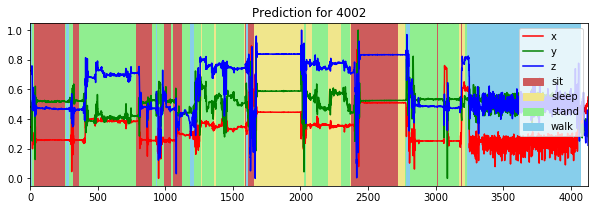

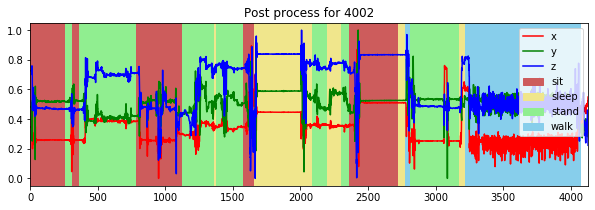

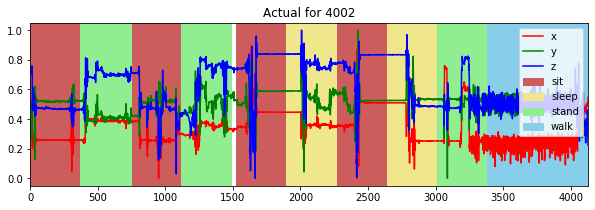

Loading 4004's data
Finished prediction
Post Process


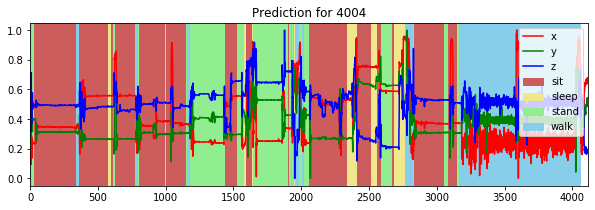

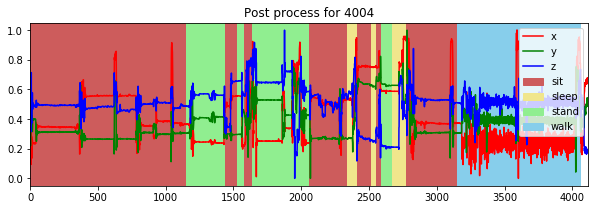

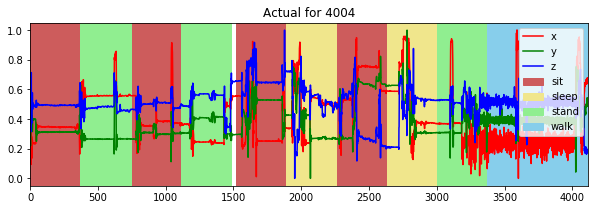

Loading 1010's data
Finished prediction
Post Process


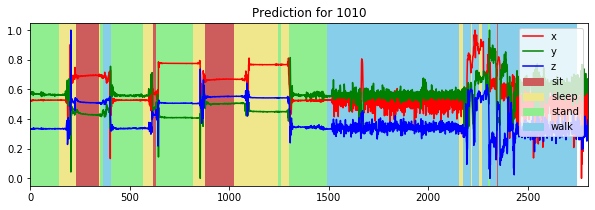

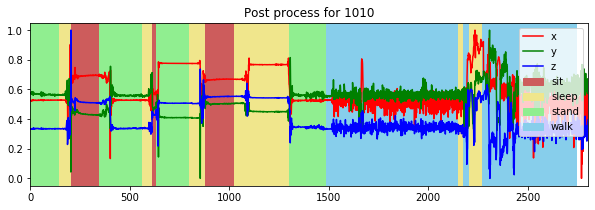

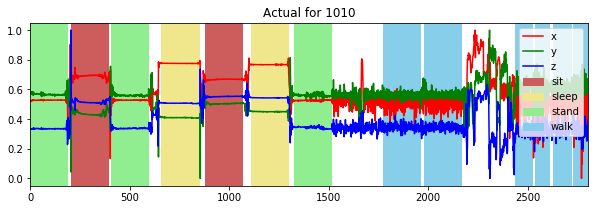

Loading 1011's data
Finished prediction
Post Process


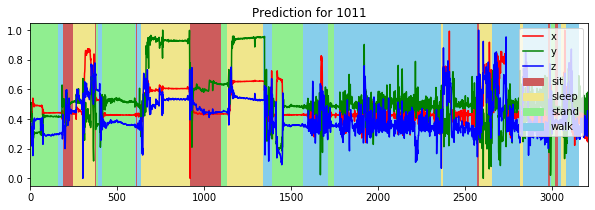

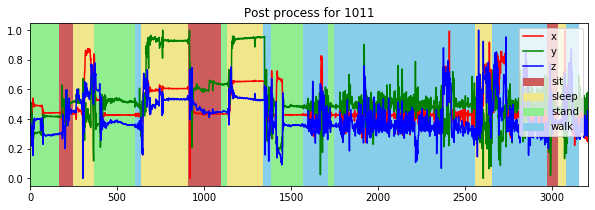

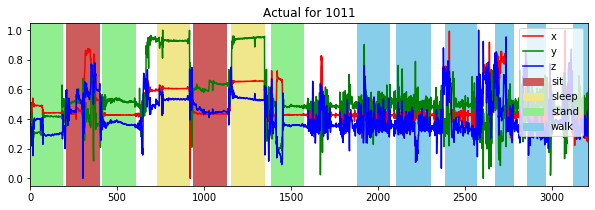

Loading 1012's data
Finished prediction
Post Process


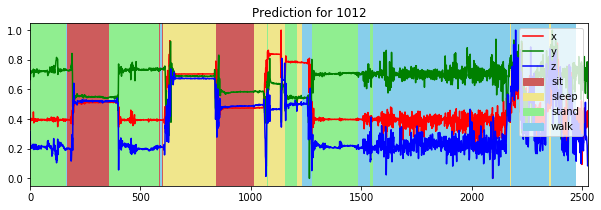

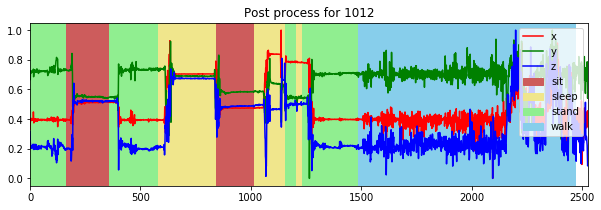

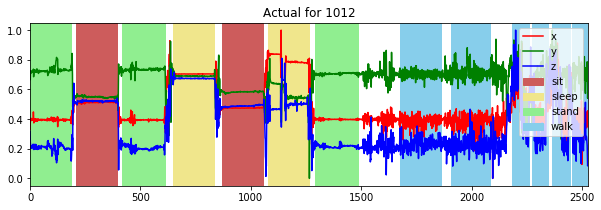

Loading 1013's data
Finished prediction
Post Process


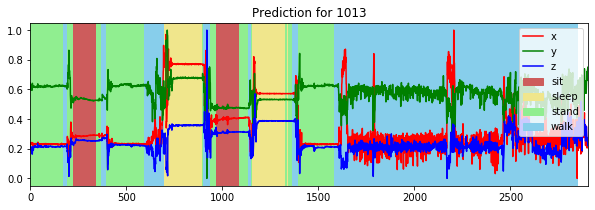

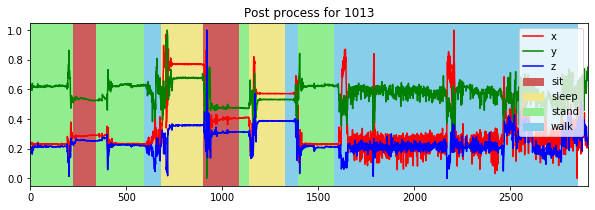

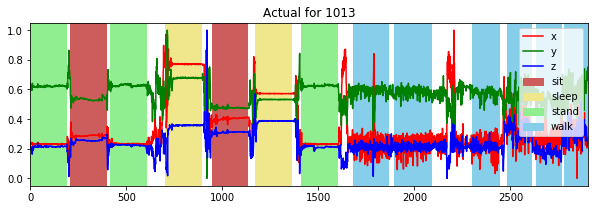

Loading 1014's data
Finished prediction
Post Process


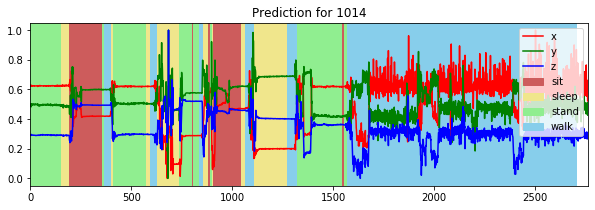

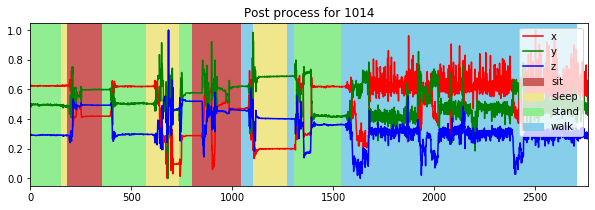

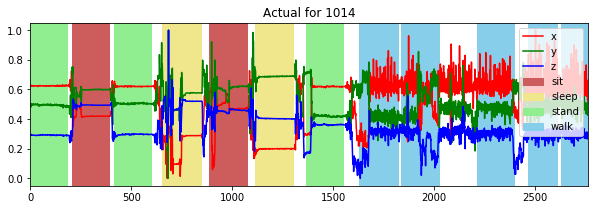

Loading 1015's data
Finished prediction
Post Process


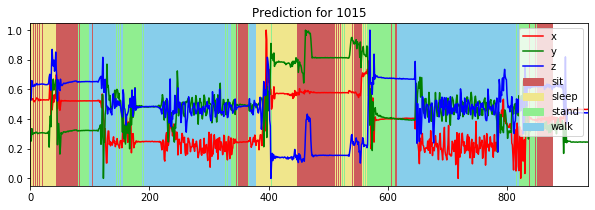

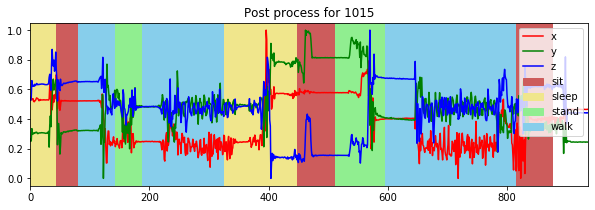

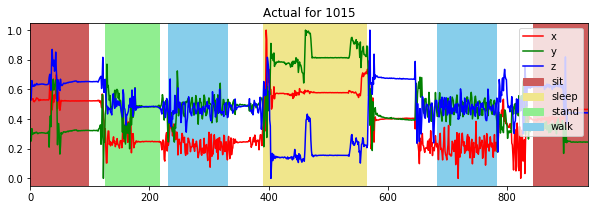

Loading 1016's data
Finished prediction
Post Process


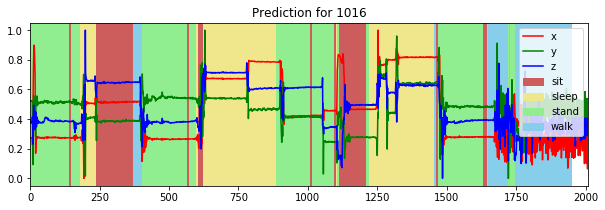

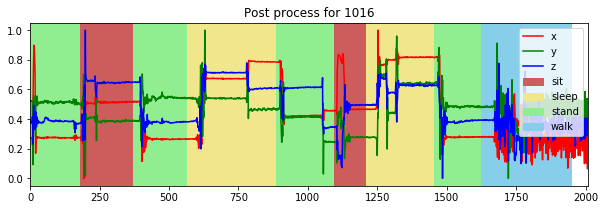

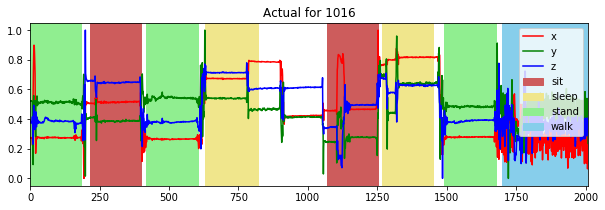

Loading 1017's data
Finished prediction
Post Process


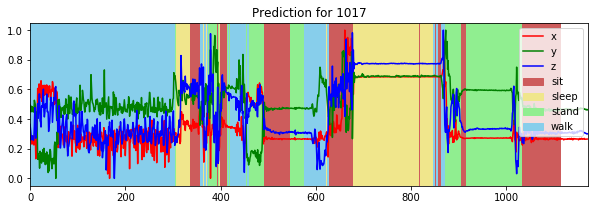

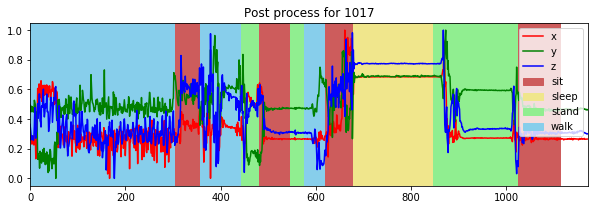

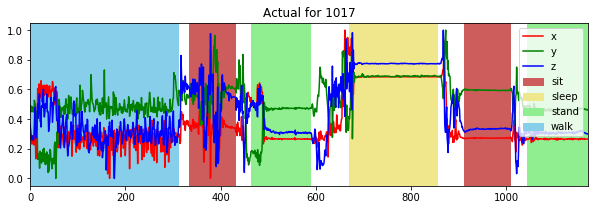

Loading 1018's data
Finished prediction
Post Process


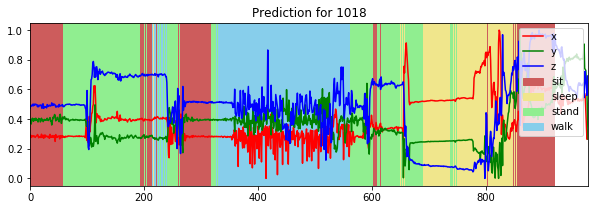

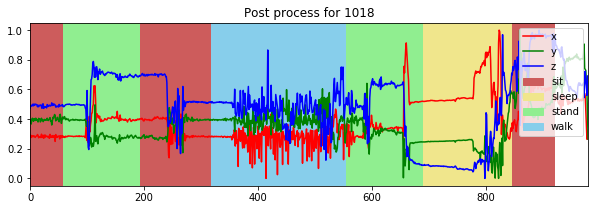

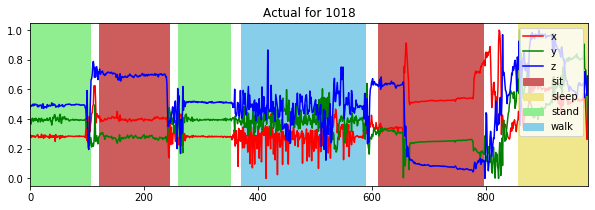

In [76]:
all_subjects = ['4002','4004','1010','1011','1012','1013','1014','1015','1016','1017','1018']
## NAME Model from loading pkg
df_y_each = call_functions_deep(all_subjects,model_93, label_list)

## Show Graph without Post Process

Loading 4002's data
Finished prediction
['sit', 'sleep', 'stand', 'walk', 'others']


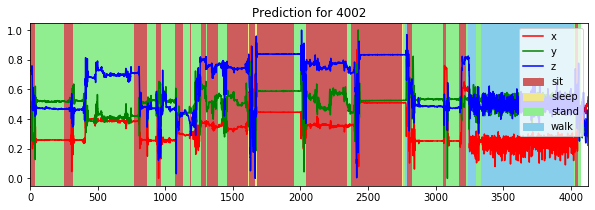

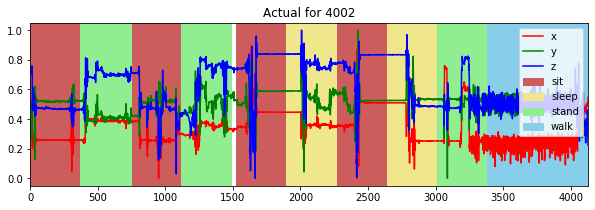

Loading 4003's data
Finished prediction
['sit', 'sleep', 'stand', 'walk', 'others']


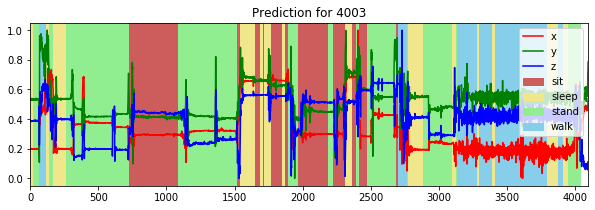

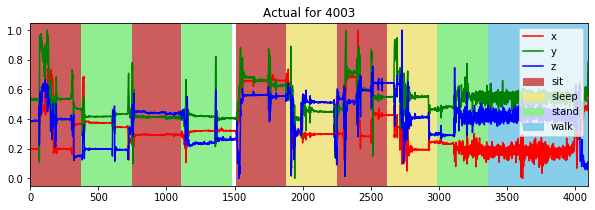

Loading 4004's data
Finished prediction
['sit', 'sleep', 'stand', 'walk', 'others']


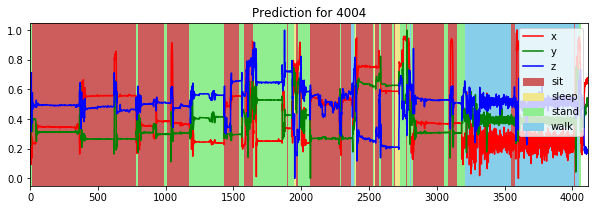

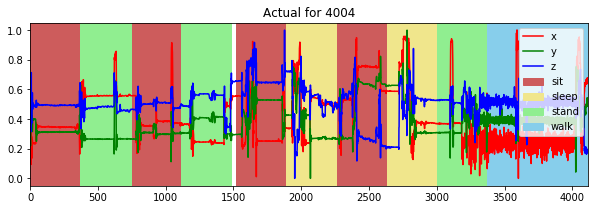

Loading 1001's data
Finished prediction
['sit', 'sleep', 'stand', 'walk', 'others']


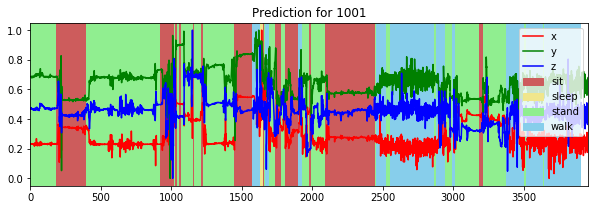

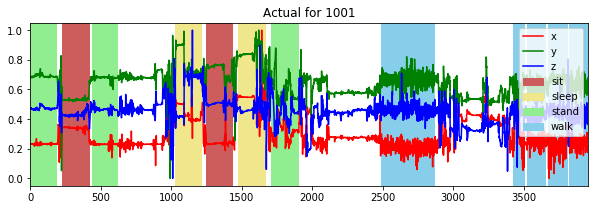

Loading 1002's data
Finished prediction
['sit', 'sleep', 'stand', 'walk', 'others']


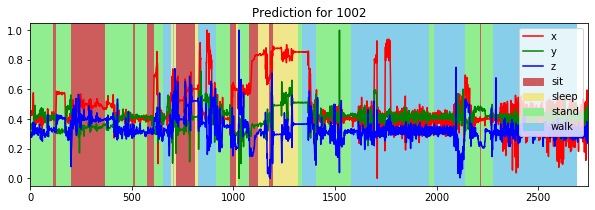

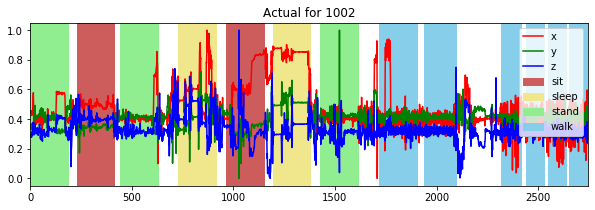

Loading 1003's data
Finished prediction
['sit', 'sleep', 'stand', 'walk', 'others']


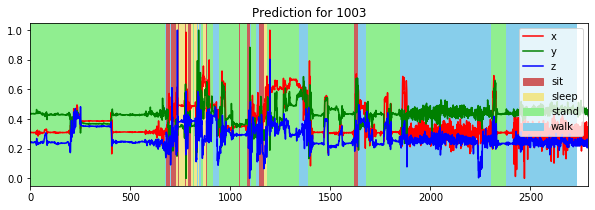

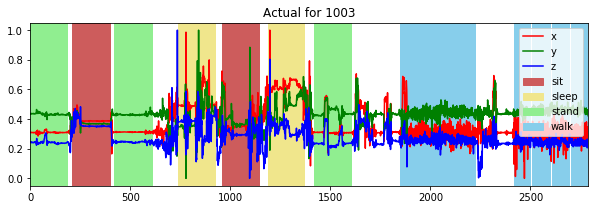

Loading 1004's data
Finished prediction
['sit', 'sleep', 'stand', 'walk', 'others']


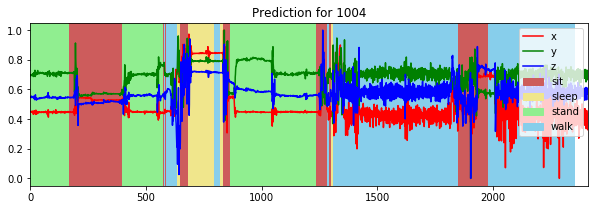

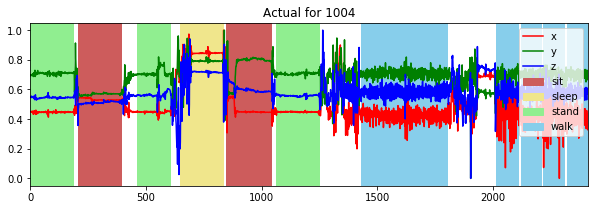

Loading 1005's data
Finished prediction
['sit', 'sleep', 'stand', 'walk', 'others']


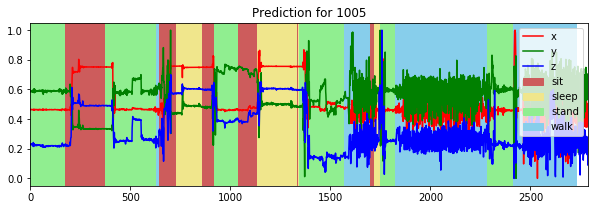

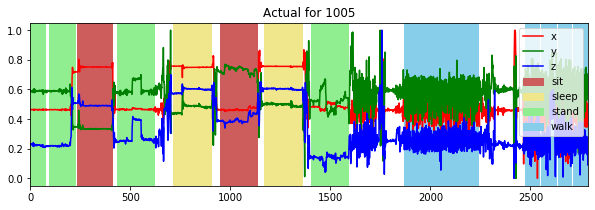

Loading 1006's data
Finished prediction
['sit', 'sleep', 'stand', 'walk', 'others']


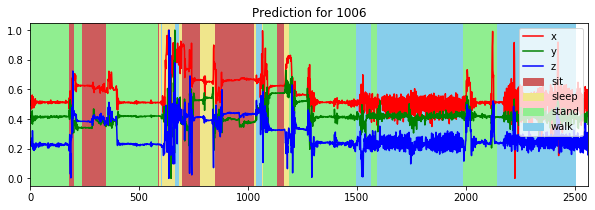

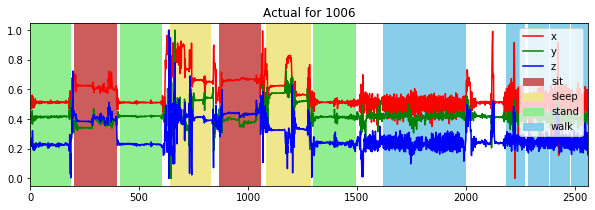

Loading 1007's data
Finished prediction
['sit', 'sleep', 'stand', 'walk', 'others']


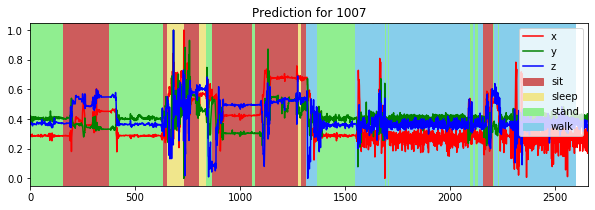

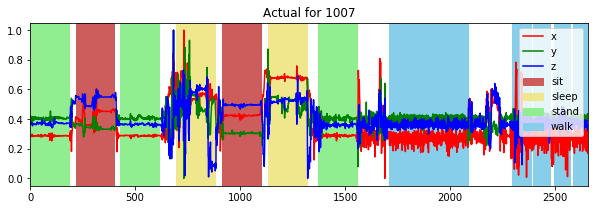

Loading 1008's data
Finished prediction
['sit', 'sleep', 'stand', 'walk', 'others']


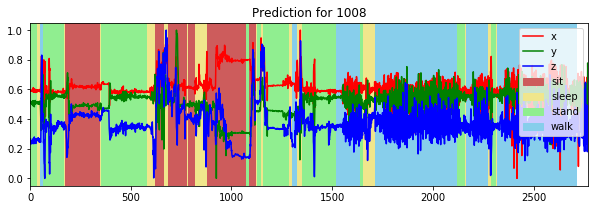

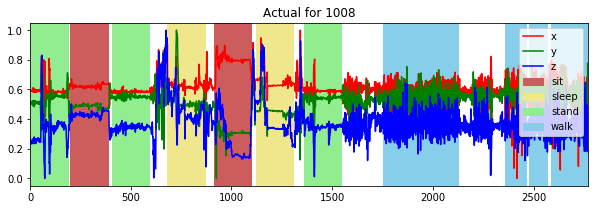

Loading 1009's data
Finished prediction
['sit', 'sleep', 'stand', 'walk', 'others']


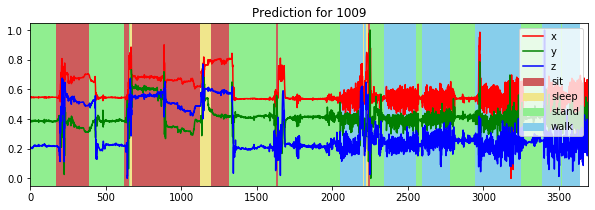

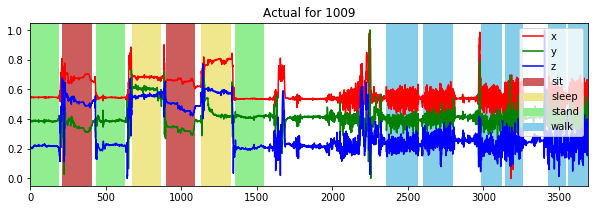

Loading 1010's data
Finished prediction
['sit', 'sleep', 'stand', 'walk', 'others']


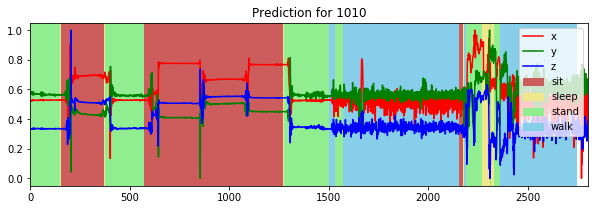

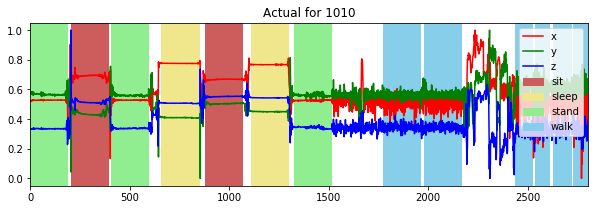

Loading 1011's data
Finished prediction
['sit', 'sleep', 'stand', 'walk', 'others']


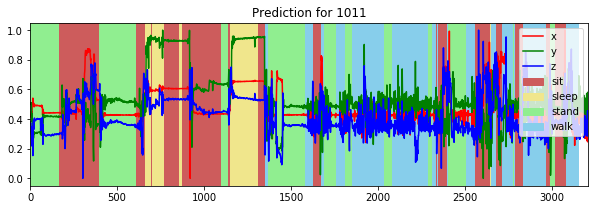

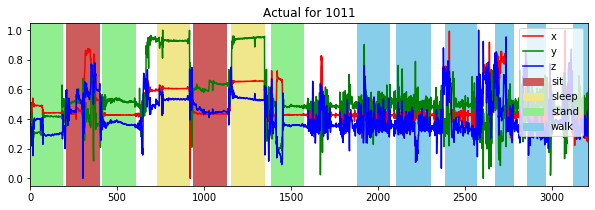

Loading 1012's data
Finished prediction
['sit', 'sleep', 'stand', 'walk', 'others']


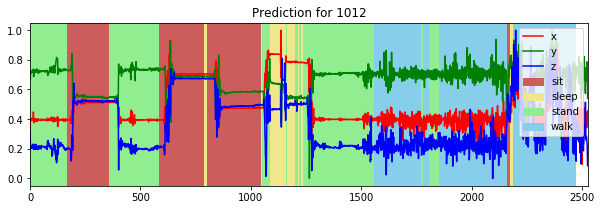

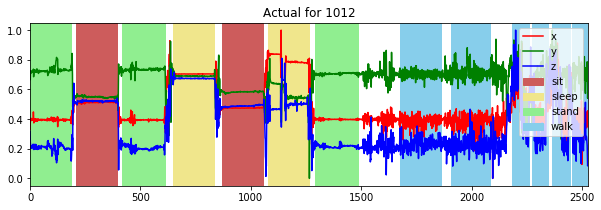

Loading 1013's data
Finished prediction
['sit', 'sleep', 'stand', 'walk', 'others']


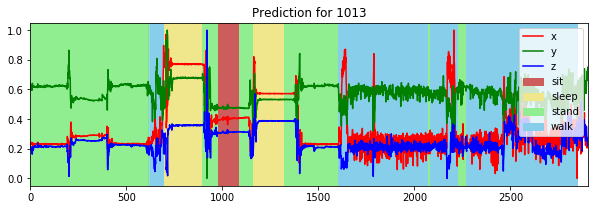

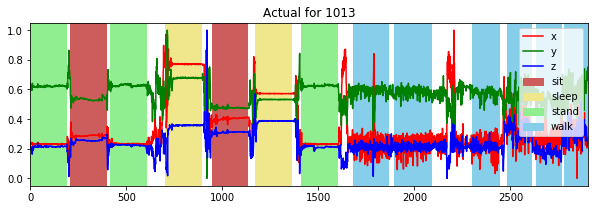

Loading 1014's data
Finished prediction
['sit', 'sleep', 'stand', 'walk', 'others']


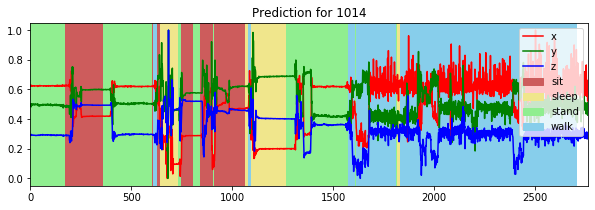

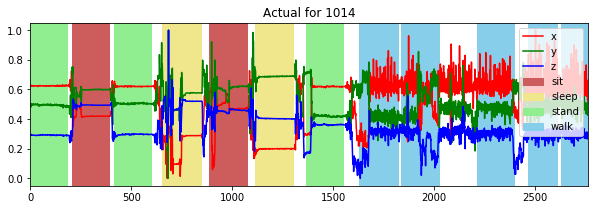

Loading 1015's data
Finished prediction
['sit', 'sleep', 'stand', 'walk', 'others']


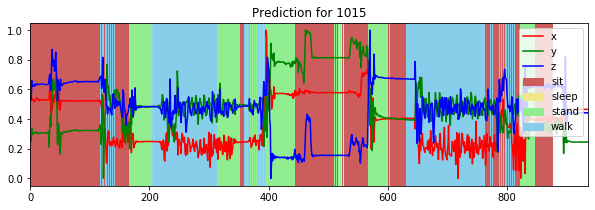

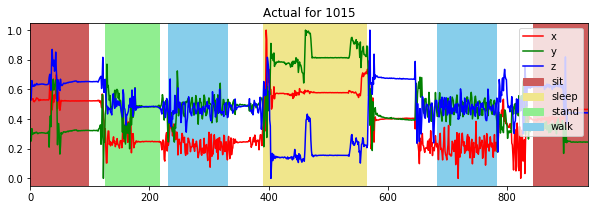

Loading 1016's data
Finished prediction
['sit', 'sleep', 'stand', 'walk', 'others']


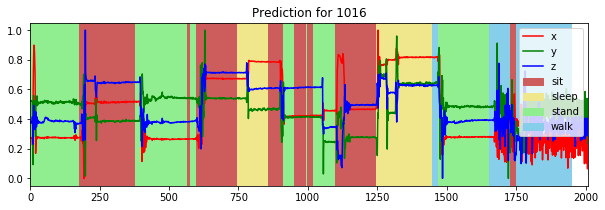

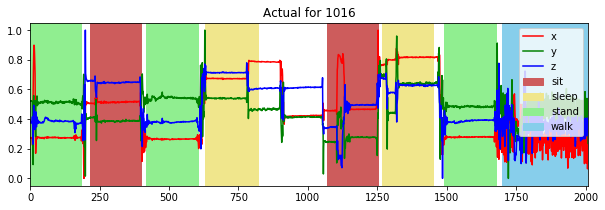

Loading 1017's data
Finished prediction
['sit', 'sleep', 'stand', 'walk', 'others']


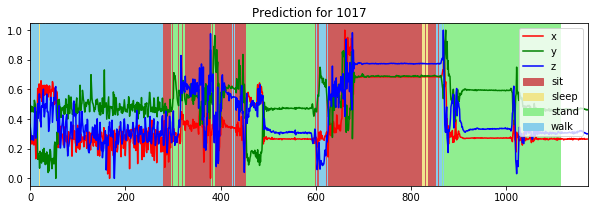

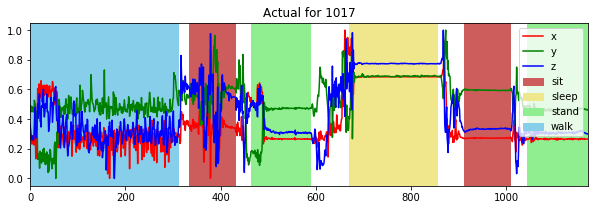

Loading 1018's data
Finished prediction
['sit', 'sleep', 'stand', 'walk', 'others']


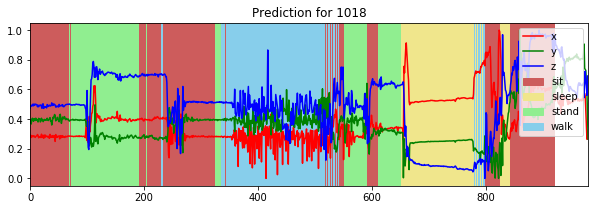

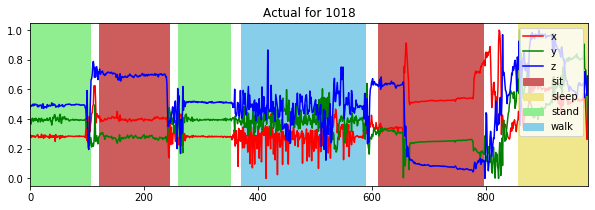

In [312]:
all_subjects = ['4002','4003','4004','1001','1002','1003','1004','1005','1006','1007','1008','1009','1010','1011','1012','1013','1014','1015','1016','1017','1018']
df_y_each = call_functions_deep(all_subjects,model_9, label_list)

Loading 3001's data
Finished prediction
['sit', 'sleep', 'stand', 'walk', 'others']


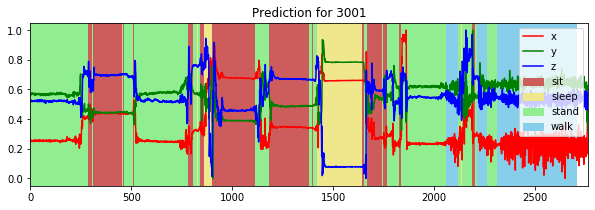

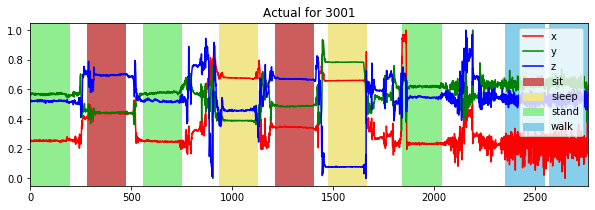

Loading 3002's data
Finished prediction
['sit', 'sleep', 'stand', 'walk', 'others']


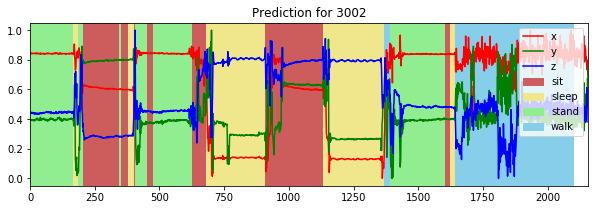

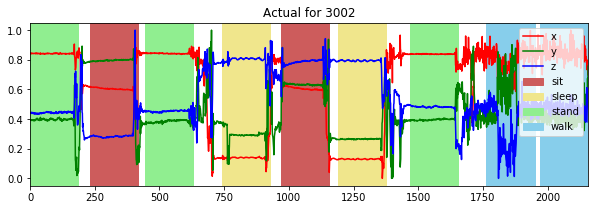

Loading 3003's data
Finished prediction
['sit', 'sleep', 'stand', 'walk', 'others']


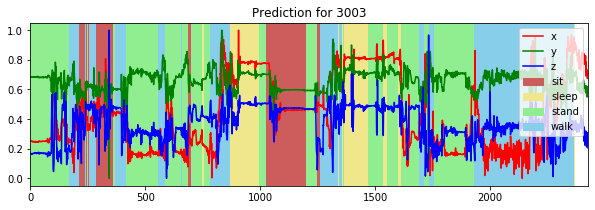

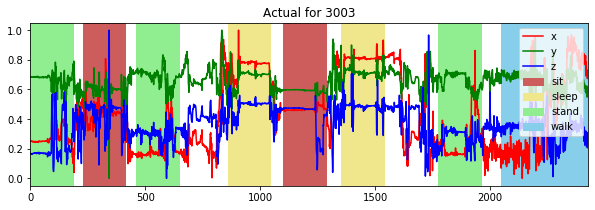

Loading 3004's data
Finished prediction
['sit', 'sleep', 'stand', 'walk', 'others']


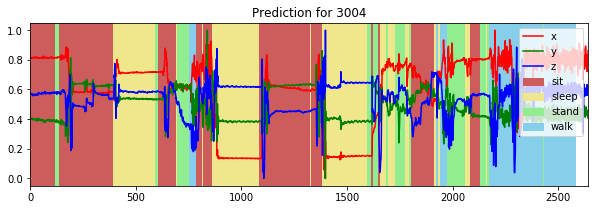

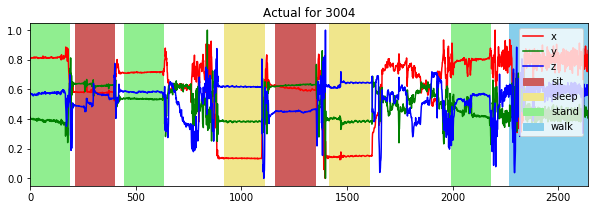

Loading 3005's data
Finished prediction
['sit', 'sleep', 'stand', 'walk', 'others']


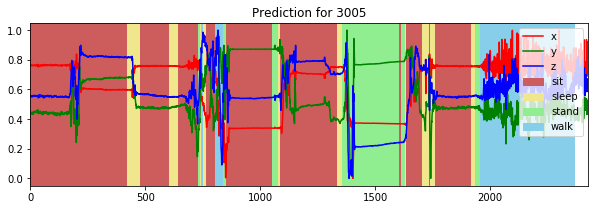

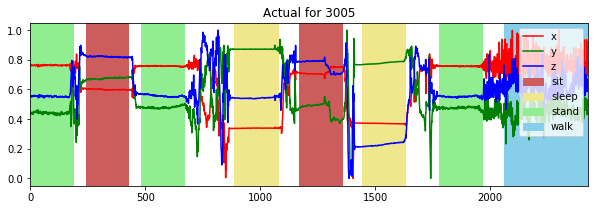

Loading 3006's data
Finished prediction
['sit', 'sleep', 'stand', 'walk', 'others']


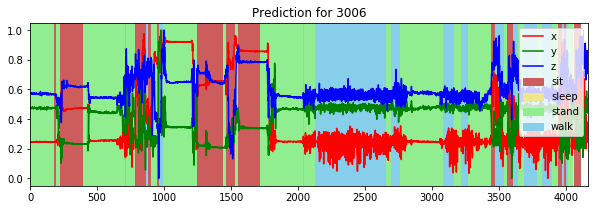

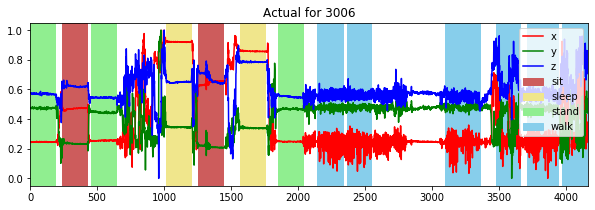

In [313]:
all_subjects = ['3001','3002','3003','3004','3005','3006']
df_y_each = call_functions_deep(all_subjects,model_9, label_list)

## Unseen Data

Loading 4001's data
Finish Loading
2019_05_03
Start pred
Finished prediction
Post Process


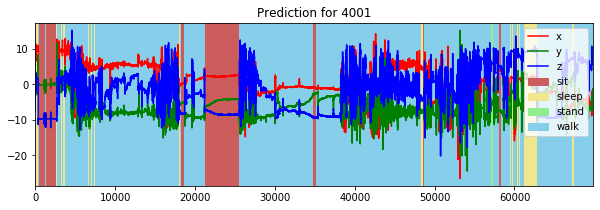

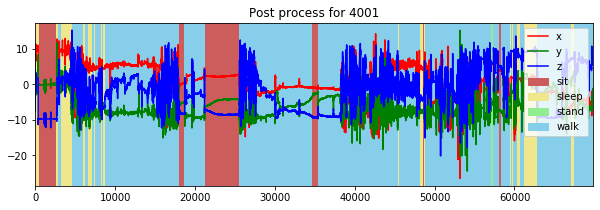

In [127]:
# ['4001','4002','4003','4004','4005','4006','4007','4008','4009','5001']
all_subjects = ['4001']
df_y_each = call_functions_test(all_subjects,model_93, label_list)

Loading 4001's data
Finish Loading
2019_05_03
Start pred
Finished prediction
Post Process


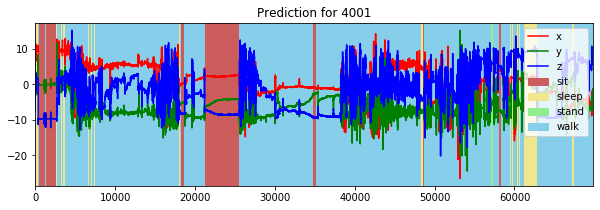

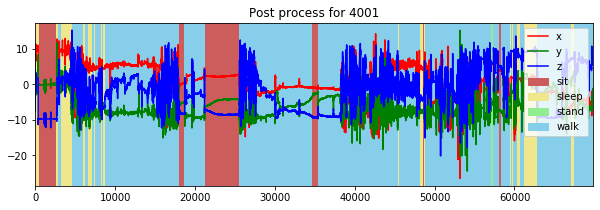

In [130]:
all_subjects = ['4001']
df_y_each = call_functions_test(all_subjects,model_93, label_list)

Loading 4001's data
Finish Loading
2019_05_10
Start pred
Finished prediction
Post Process


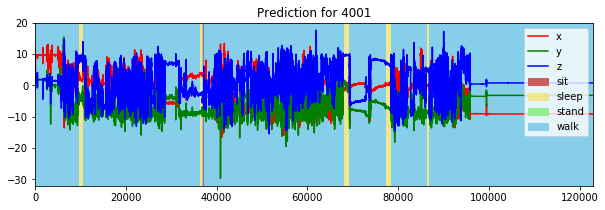

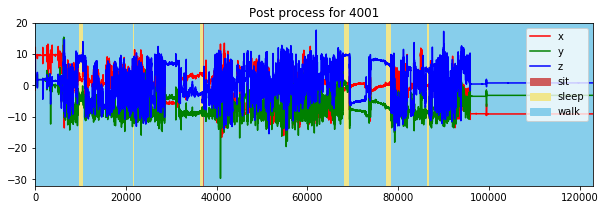

In [134]:
all_subjects = ['4001']
df_y_each = call_functions_test(all_subjects,model_93, label_list)

In [144]:
%run test_model.ipynb

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator SVC from version 0.19.2 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Loading 4001's data
Finish Loading
2019_05_24
Start pred
Finished prediction
Post Process


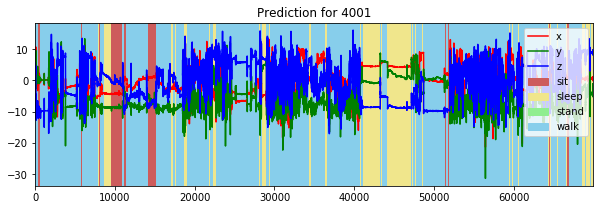

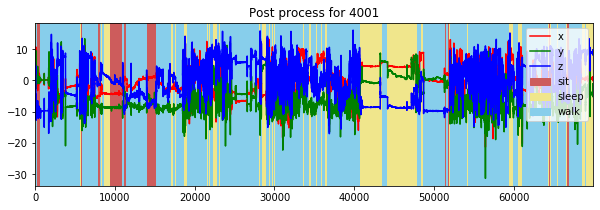

In [145]:
all_subjects = ['4001']
df_y_each = call_functions_test(all_subjects,model_93, label_list)

Loading 4002's data
Finish Loading
2019_04_02
Start pred
Finished prediction
Post Process


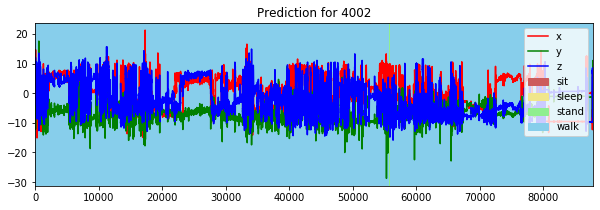

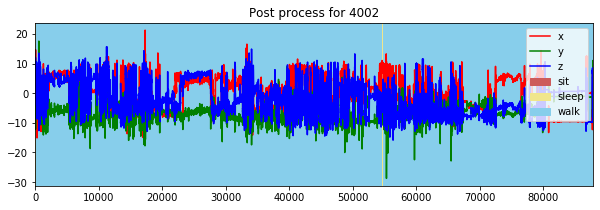

In [143]:
all_subjects = ['4002']
df_y_each = call_functions_test(all_subjects,model_93, label_list)

Loading 4003's data
Finish Loading
2019_04_02
Start pred
Finished prediction


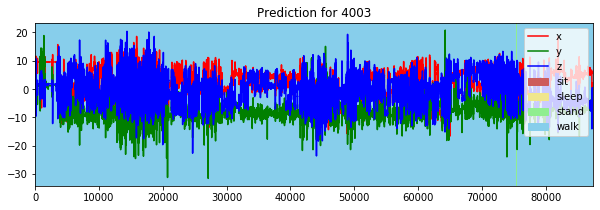

In [257]:
all_subjects = ['4003']
df_y_each = call_functions_test(all_subjects,model_9, label_list)

Loading 4003's data
Finish Loading
2019_05_03
Start pred
Finished prediction


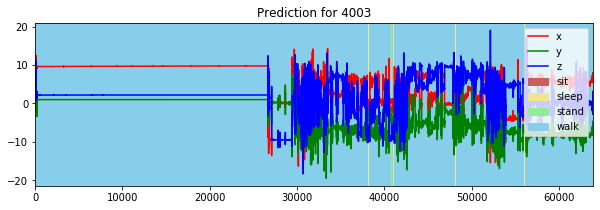

In [259]:
all_subjects = ['4003']
df_y_each = call_functions_test(all_subjects,model_9, label_list)

Loading 4003's data
Finish Loading
2019_05_24
Start pred
Finished prediction


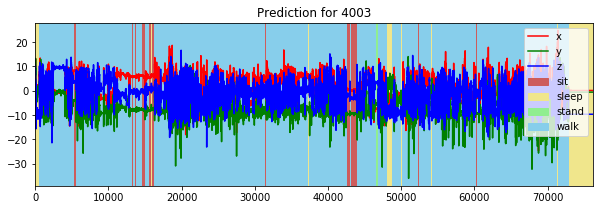

In [261]:
all_subjects = ['4003']
df_y_each = call_functions_test(all_subjects,model_9, label_list)

Loading 4004's data
Finish Loading
2019_03_29
Start pred
Finished prediction


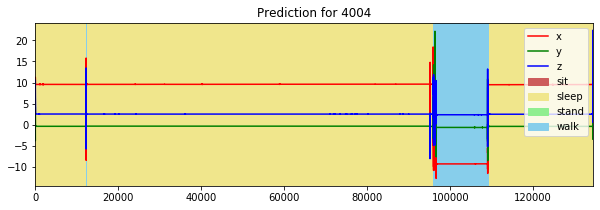

In [263]:
all_subjects = ['4004']
df_y_each = call_functions_test(all_subjects,model_9, label_list)

Loading 4004's data
Finish Loading
2019_05_03
Start pred
Finished prediction


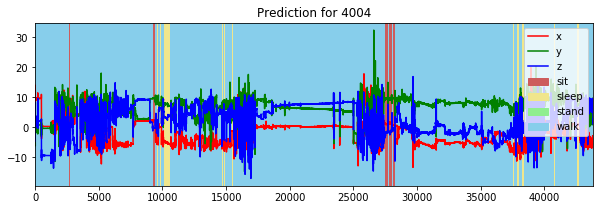

In [265]:
all_subjects = ['4004']
df_y_each = call_functions_test(all_subjects,model_9, label_list)

Loading 4004's data
Finish Loading
2019_05_10
Start pred
Finished prediction


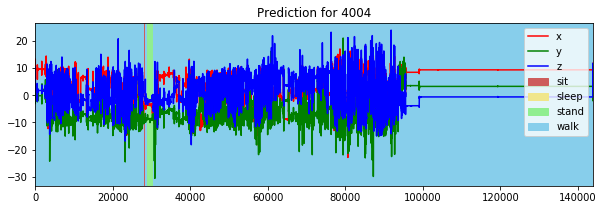

In [267]:
all_subjects = ['4004']
df_y_each = call_functions_test(all_subjects,model_9, label_list)

Loading 4004's data
Finish Loading
2019_05_24
Start pred
Finished prediction


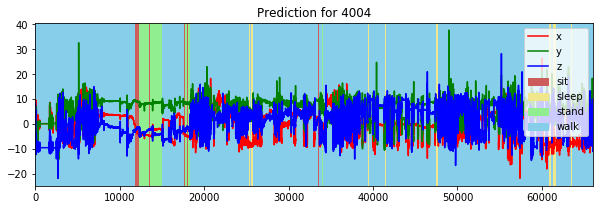

In [269]:
all_subjects = ['4004']
df_y_each = call_functions_test(all_subjects,model_9, label_list)

Loading 4005's data
Finish Loading
2019_04_02
Start pred
Finished prediction


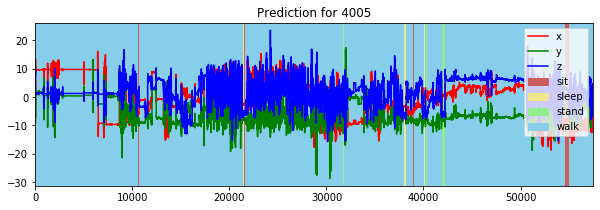

In [271]:
all_subjects = ['4005']
df_y_each = call_functions_test(all_subjects,model_9, label_list)

Loading 4006's data
Finish Loading
2019_04_02
Start pred
Finished prediction


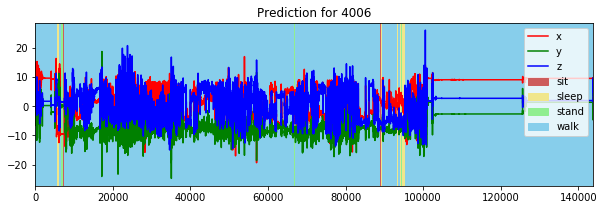

In [273]:
all_subjects = ['4006']
df_y_each = call_functions_test(all_subjects,model_9, label_list)

Loading 4007's data
Finish Loading
2019_04_02
Start pred
Finished prediction


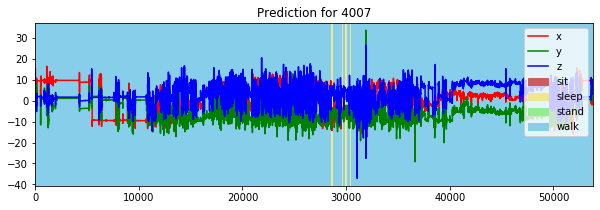

In [275]:
all_subjects = ['4007']
df_y_each = call_functions_test(all_subjects,model_9, label_list)

Loading 4008's data
Finish Loading
2019_05_10
Start pred
Finished prediction


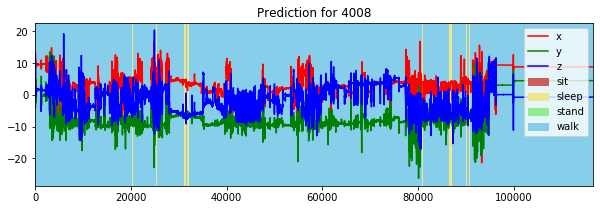

In [279]:
all_subjects = ['4008']
df_y_each = call_functions_test(all_subjects,model_9, label_list)

Loading 4009's data
Finish Loading
2019_05_10
Start pred
Finished prediction


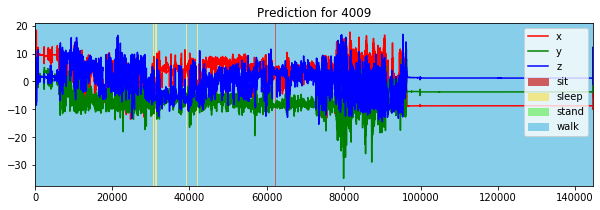

In [281]:
all_subjects = ['4009']
df_y_each = call_functions_test(all_subjects,model_9, label_list)

Loading 5001's data
Finish Loading
2019_06_22
Start pred
Finished prediction


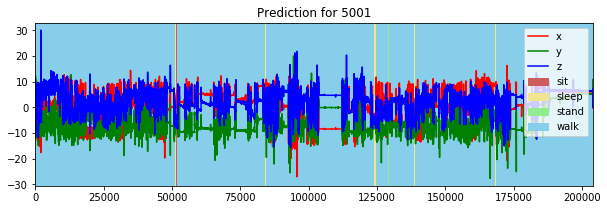

In [283]:
all_subjects = ['5001']
df_y_each = call_functions_test(all_subjects,model_9, label_list)

Loading 5001's data
Finish Loading
2019_06_23
Start pred
Finished prediction


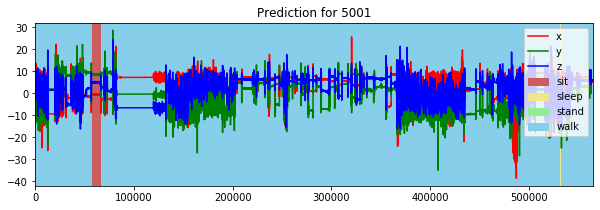

In [285]:
all_subjects = ['5001']
df_y_each = call_functions_test(all_subjects,model_9, label_list)

Loading 5001's data
Finish Loading
2019_06_24
Start pred
Finished prediction


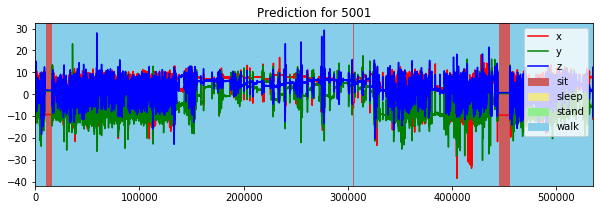

In [287]:
all_subjects = ['5001']
df_y_each = call_functions_test(all_subjects,model_9, label_list)

Loading 5001's data
Finish Loading
2019_06_25
Start pred
Finished prediction


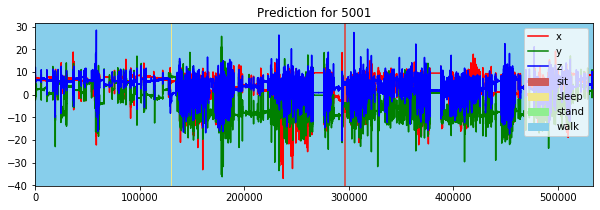

In [289]:
all_subjects = ['5001']
df_y_each = call_functions_test(all_subjects,model_9, label_list)

Loading 5001's data
Finish Loading
2019_06_26
Start pred
Finished prediction


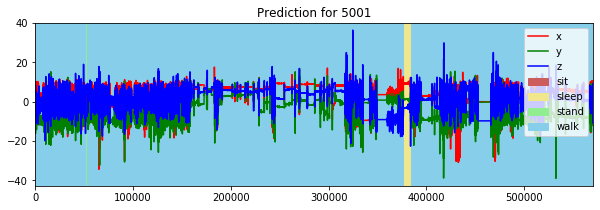

In [291]:
all_subjects = ['5001']
df_y_each = call_functions_test(all_subjects,model_9, label_list)

Loading 5001's data
Finish Loading
2019_06_27
Start pred
Finished prediction


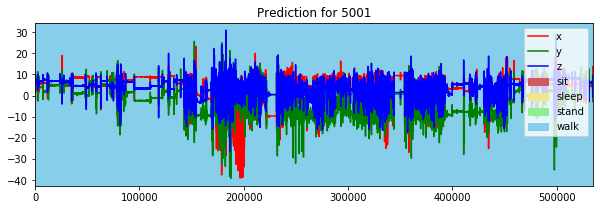

In [293]:
all_subjects = ['5001']
df_y_each = call_functions_test(all_subjects,model_9, label_list)

Loading 5001's data
Finish Loading
2019_06_28
Start pred
Finished prediction


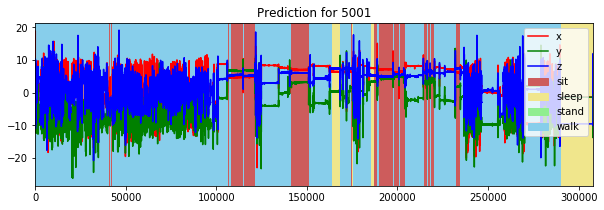

In [298]:
all_subjects = ['5001']
df_y_each = call_functions_test(all_subjects,model_9, label_list)